In [2]:
import os
import time
import scipy.io as sio
import sys
import numpy as np

# **Loading the stimulus**

In [3]:
stim_file_name = r'/kaggle/input/surfaceinvariance/rsurf.mat'
stim_data = sio.loadmat(stim_file_name)
stim_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Mar 11 14:09:03 2018',
 '__version__': '1.0',
 '__globals__': [],
 'stim': array([[array([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                ...,
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
  

In [4]:
# stim_data['stim']
#stim_data['stim'][77][0].shape
stims = stim_data['stim'].flatten()
stims[77].shape

(400, 400, 3)

In [5]:
# Networks
types = ['imagenet-vgg-verydeep-16', 'imagenet-matconvnet-vgg-verydeep-16.mat', 'imagenet-vgg-verydeep-16_randn.mat', 'imagenet-vgg-face','imagenet-caffe-alex','imagenet-googlenet-dag','imagenet-resnet-50-dag','imagenet-resnet-152-dag']
dagg_flag = [0, 0, 0, 0, 0, 1, 1, 1]
network_short_name = ['VGG-16', 'mat.VGG-16', 'VGG-16 randn', 'VGG-face', 'Alexnet', 'Goolgenet', 'ResNet 50', 'ResNet 152']

# **Forward pass through VGG-16 neural network**

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):

#     print(x)
    n=len(net.features) + len(net.classifier)
    print("LEn:",n)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        
        for  (sub_name, sub_layer) in (layer.named_children()):
            print("Iteration:",i)
#             print(sub_layer)
            ltype=sub_layer.__class__.__name__
            print(f"  Type: {sub_layer.__class__.__name__}")

    # res[i]['time'] = time.time()
            if ltype == 'Conv2d':
                print(res[i]['x'].shape,sub_layer.weight.shape,sub_layer.bias.shape)
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'], padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
#                 temp= nn.Linear(res[i]['x'].flatten().shape[0], 4096)
#                 res[i + 1]['x'] = torch.tensor(temp),dtype=torch.float32
            elif ltype=='Dropout':
                i=i-1
#                 dropout_layer = CustomDropout(p=0.5)
#                 print(dropout_layer)
#                 res[i + 1]['x'] = dropout_layer
            elif ltype== 'ReLU':
                # if l['leak'] > 0:
                #     leak = {'leak': l['leak']}
                # else:
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1

    return res

# **Feature Extraction for VGG-16**

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag, run_path, pretrained=True):
    # Load the VGG16 model
    model = vgg16(pretrained=pretrained)
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract the image data from the loaded dictionary
    #stim_images = stim_data['stim'][0]
    nimages = len(stim_data)
    print(nimages)
    if dagg_flag==0:
        features = []
        for ind in range(nimages):
            # Convert the numpy array to PIL Image
            image_array = stim_data[ind].astype(np.uint8)
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
            print(image_tensor.shape)
                # Perform inference using the model
            with torch.no_grad():
                output = model(image_tensor)

            # Append the features to the list
            features.append(vl_simplenn(model, image_tensor))
        print('Done')
    return features

In [8]:
reference_mi = 0.55
reference_name = 'Ratan Murty & Arun 2016'
grey_region_name = 'IT Interaction effect for 9% of tetrads'
y_label = 'average of surface invariance index for top 9 % tetrads'
run_path = r'/'

# **Check Surface Invariance**

In [9]:
import numpy as np
from scipy.stats import sem
from numpy.linalg import norm

def check_rsurf_effect(features):
    nimages = len(features)
    nL = len(features[0]) - 2
    nSETS = 6
    nGroups = 4
    nStimPerSet = 13
    percentage_selected = 0.09

    miLayerwise_selected_mean = np.zeros(nL)
    miLayerwise_selected_sem = np.zeros(nL)
    nTetrad = np.zeros((nL, nSETS * nGroups))
    array_neuron_stats = np.zeros((nL, 3))  # neurons per layer, visually active neurons, tetrads showing positive RE

    for layerid in range(nL):
        print(f'\n Layer - {layerid + 1}')
        # getting response and normalizing
        nNeurons = len(features[0][layerid]['x'].flatten())
        array_neuron_stats[layerid, 0] = nNeurons
        response = np.array([features[ind][layerid]['x'].flatten() for ind in range(nimages)]).T
        nresponse = (response - response.min(axis=0)) / (response.max(axis=0) - response.min(axis=0))

        van = np.where(np.sum(nresponse, axis=1) > 0)[0]  # visually active neurons
        nvresponse = nresponse[van, :]  # normalized response from visually active neurons
        nvan = len(van)
        array_neuron_stats[layerid, 1] = nvan / nNeurons
        # init
        RE_L = np.zeros((nvan, nSETS * nGroups))  # residual error
        selected_tetrads = np.zeros((nvan, nSETS * nGroups))  # selected tetrads
        MI_L = np.zeros((nresponse.shape[0], nSETS * nGroups))  # modulation index layerwise
        MI_L_average = []
        count = 0
        MIn = np.zeros((nvan, nSETS * nGroups))

        for set in range(nSETS):
            set_start = nStimPerSet * (set - 1) + 1
            for group in range(nGroups):
                count += 1
                imag = set_start + np.array([0, (group - 1) * 3 + 1, (group - 1) * 3 + 2, (group - 1) * 3 + 3])

                n_img1 = nresponse[van, imag[0]]
                n_img2 = nresponse[van, imag[1]]
                n_img3 = nresponse[van, imag[2]]
                n_img4 = nresponse[van, imag[3]]
                temp_sum = n_img1 + n_img2 + n_img3 + n_img4
                n_active_tertads = np.sum(temp_sum > 0)
                nTetrad[layerid, count - 1] = n_active_tertads
                index = np.where(temp_sum <= 0)[0]
                n_img1[index] = np.nan
                n_img2[index] = np.nan
                n_img3[index] = np.nan
                n_img4[index] = np.nan
                mr1 = (n_img1 + n_img2) / 2
                mr2 = (n_img3 + n_img4) / 2
                mc1 = (n_img1 + n_img3) / 2
                mc2 = (n_img2 + n_img4) / 2
                T = np.vstack([n_img1, n_img2, n_img3, n_img4]).T
                re = T + np.mean(T, axis=1, keepdims=True) - np.vstack([mr1, mr1, mr2, mr2]).T - np.vstack([mc1, mc2, mc1, mc2]).T
                RE_L[:, count - 1] = np.sum(np.abs(re), axis=1)
                d14 = np.abs(n_img1 - n_img4)
                d23 = np.abs(n_img2 - n_img3)
                MIn[:, count - 1] = (d23 - d14) / (d14 + d23)

        MIn_selected = MIn.flatten()
        vectorized_RE_L = RE_L.flatten()
        vectorized_RE_L[np.isnan(vectorized_RE_L)] = -9999999
        tempV, tempI = np.sort(vectorized_RE_L)[::-1], np.argsort(vectorized_RE_L)[::-1]
        count_active_tetrads = np.sum(nTetrad[layerid, :])

        temp_number = int(np.floor(percentage_selected * count_active_tetrads))
        array_neuron_stats[layerid, 2] = temp_number / (nNeurons * nSETS * nGroups)
        selected_tetrads = selected_tetrads.flatten()
        selected_tetrads[tempI[:temp_number]] = 1
        MIn_selected[selected_tetrads == 0] = np.nan

        print(f'\nAmong Selected ( max RE = {np.nanmax(tempV[:temp_number]):.2f} min RE = {np.nanmin(tempV[:temp_number]):.2f} )')
        miLayerwise_selected_mean[layerid] = np.nanmean(MIn_selected)
        miLayerwise_selected_sem[layerid] = sem(MIn_selected, nan_policy='omit')

    return miLayerwise_selected_mean, miLayerwise_selected_sem


In [ ]:
print('\n Extracting Features from VGG-16\n')
features = extract_features(stims, types[0], dagg_flag[0], run_path, pretrained=True)
miLayerwise_selected_mean_v1, miLayerwise_selected_sem_v1 = check_rsurf_effect(features)


 Extracting Features



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 134MB/s]  


78
torch.Size([1, 3, 224, 224])
LEn: 38
Iteration: 0
  Type: Conv2d
torch.Size([1, 3, 224, 224]) torch.Size([64, 3, 3, 3]) torch.Size([64])
Iteration: 1
  Type: ReLU
Iteration: 2
  Type: Conv2d
torch.Size([1, 64, 224, 224]) torch.Size([64, 64, 3, 3]) torch.Size([64])
Iteration: 3
  Type: ReLU
Iteration: 4
  Type: MaxPool2d
Iteration: 5
  Type: Conv2d
torch.Size([1, 64, 112, 112]) torch.Size([128, 64, 3, 3]) torch.Size([128])
Iteration: 6
  Type: ReLU
Iteration: 7
  Type: Conv2d
torch.Size([1, 128, 112, 112]) torch.Size([128, 128, 3, 3]) torch.Size([128])
Iteration: 8
  Type: ReLU
Iteration: 9
  Type: MaxPool2d
Iteration: 10
  Type: Conv2d
torch.Size([1, 128, 56, 56]) torch.Size([256, 128, 3, 3]) torch.Size([256])
Iteration: 11
  Type: ReLU
Iteration: 12
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 13
  Type: ReLU
Iteration: 14
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 15

In [ ]:
print('\n Extracting Features from VGG-16 random\n')
features = extract_features(stims, types[0], dagg_flag[0], run_path, pretrained=False)
miLayerwise_selected_mean_v2, miLayerwise_selected_sem_v2 = check_rsurf_effect(features)


 Extracting Features from VGG-16 random



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


78
torch.Size([1, 3, 224, 224])
LEn: 38
Iteration: 0
  Type: Conv2d
torch.Size([1, 3, 224, 224]) torch.Size([64, 3, 3, 3]) torch.Size([64])
Iteration: 1
  Type: ReLU
Iteration: 2
  Type: Conv2d
torch.Size([1, 64, 224, 224]) torch.Size([64, 64, 3, 3]) torch.Size([64])
Iteration: 3
  Type: ReLU
Iteration: 4
  Type: MaxPool2d
Iteration: 5
  Type: Conv2d
torch.Size([1, 64, 112, 112]) torch.Size([128, 64, 3, 3]) torch.Size([128])
Iteration: 6
  Type: ReLU
Iteration: 7
  Type: Conv2d
torch.Size([1, 128, 112, 112]) torch.Size([128, 128, 3, 3]) torch.Size([128])
Iteration: 8
  Type: ReLU
Iteration: 9
  Type: MaxPool2d
Iteration: 10
  Type: Conv2d
torch.Size([1, 128, 56, 56]) torch.Size([256, 128, 3, 3]) torch.Size([256])
Iteration: 11
  Type: ReLU
Iteration: 12
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 13
  Type: ReLU
Iteration: 14
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 15

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
  #  plt.savefig(file_name + '.pdf')
    plt.show()

/tmp/ipykernel_157/1456367342.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


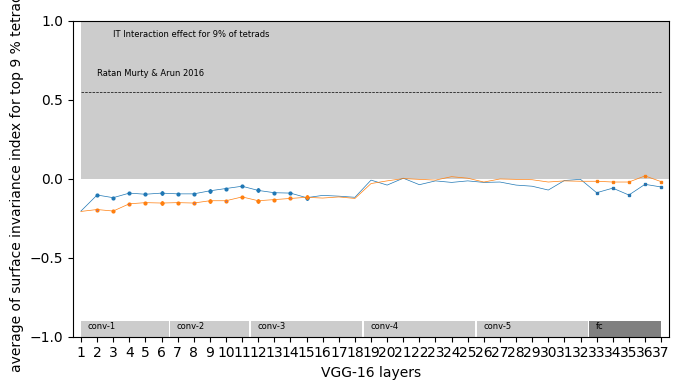

In [3]:
reference_mi = 0.55
reference_name = 'Ratan Murty & Arun 2016'
grey_region_name = 'IT Interaction effect for 9% of tetrads'
y_label = 'average of surface invariance index for top 9 % tetrads'
file_name = 'name'

mean_data = [miLayerwise_selected_mean_v1, miLayerwise_selected_mean_v2]
layerwise_mi_figures(mean_data, [], file_name, reference_mi, reference_name, ['VGG16,VGG16_rand'], y_label, shaded_region_name=grey_region_name)